# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# 1 Project Definition
## 1.1 Project Overview
As a company, it is important to have an efficient promotional spend that can maximize revenue, while maintaining promotional cost as low as possible. One of the way to achieve the goals is by understanding the customer behavior to know which promotion works for which segment. Creating tailored offering based on specific customer traits will hopefully increase the return in promotional spend.

In this project, we are using Starbucks real promotions data to try understand customers behavior and achieve the above objective. 

## 1.2 Problem Statement

Starbucks run a test to create the data simulates how people make purchasing decisions and how those decisions are influenced by promotional offers.

Each person in the simulation has some hidden traits that influence their purchasing patterns and are associated with their observable traits. People produce various events, including receiving offers, opening offers, and making purchases.As a simplification, there are no explicit products to track. Only the amounts of each transaction or offer are recorded.

There are three types of offers that can be sent: buy-one-get-one (BOGO), discount, and informational. In a BOGO offer, a user needs to spend a certain amount to get a reward equal to that threshold amount. In a discount, a user gains a reward equal to a fraction of the amount spent. In an informational offer, there is no reward, but neither is there a requisite amount that the user is expected to spend. Offers can be delivered via multiple channels.

The basic task is to use the data to :<br><br>
`1.` Identify which groups of people are most responsive to each type of offer? <br>
Starbucks attracts a diverse type of consumers, whether they are old or young, aspire, or affluent. Each of these customers responds differently from one promotion to the other. I want to group them based on their responses and demography info so they can get more targetted advertising based on their prior answers.
KMeans algorithm will be used to group these people, and PCA will be conducted to identify the most prominent variables focusing on the completion rate of an offer.<br><br>
`2.` How best to present each type of offer?<br>
After each customer is grouped, using descriptive statistics, we explore what the promotion that most completed by each group are. Taking into account their income, age, and gender, we can further tailored the messaging and price points for them.

## 1.3 Metrics 
First, we want to have as dense as possible within the group; the WCS metric will be used. Within-Cluster-Sum-of-Squares (WCSS) is the summation of observations from their cluster centroids.

![]("formula.png")
Where Yi is centroid for observation Xi.

Next, to know which WCSS number is optimal, we plot the WCSS value against the number of clusters to identify "elbow" curve. This is based on the principle that while clustering performance as measured by WCSS increases (i.e., WCSS decreases) with an increase in k, the rate of growth is usually decreasing. Plotting WCSS against increasing k can show an 'elbow' which remarks a significant drop in the rate of increase.

# 2 Analysis
## 2.1 Exploration and Visualization

In [1]:
# import libraries

import pandas as pd
import numpy as np
import math
import json
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
from datetime import datetime
from numpy import nansum
from numpy import nanmean


# magic word for producing visualizations in notebook
%matplotlib inline

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [3]:
####
#    Conduct data quality checking for dataframe
#    
#    INPUT: 
#        df: dataframe to be checked
#        
#    OUTPUT: 
#        none
####

def quick_diagnostics (df):
    # Quick diagnostic
    print("Shape :", df.shape,"\n")
    print("\nFeatures :", df.columns.tolist(),"\n")
    print("\nNull values :\n", df.isnull().sum(),"\n")
    print("\nDescriptive statistics:\n", df.describe(include="all"))

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

### 2.1.1 Transcript
There are 300k rows with no missing values with 1700 unique customer transacting. Format are mostly ready to use with an exception on 'value' column. As for 'value', column need to preprocess to break json like format into few more columns that identified as key within the json like format. 

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


Shape : (306534, 4) 


Features : ['person', 'event', 'value', 'time'] 


Null values :
 person    0
event     0
value     0
time      0
dtype: int64 



TypeError: unhashable type: 'dict'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas\_libs\hashtable_class_helper.pxi", line 1652, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'dict'



Descriptive statistics:
                                   person        event  \
count                             306534       306534   
unique                             17000            4   
top     94de646f7b6041228ca7dec82adb97d2  transaction   
freq                                  51       138953   
mean                                 NaN          NaN   
std                                  NaN          NaN   
min                                  NaN          NaN   
25%                                  NaN          NaN   
50%                                  NaN          NaN   
75%                                  NaN          NaN   
max                                  NaN          NaN   

                                                   value           time  
count                                             306534  306534.000000  
unique                                              5121            NaN  
top     {'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}           

None

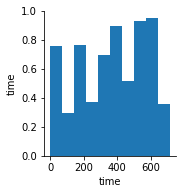

In [4]:
# Transcript
display(transcript.head(5))
sns.pairplot(transcript)
display(quick_diagnostics(transcript))

### 2.1.2 Portfolio
This table has 10 rows indicating the type of promotions. Data is very clean with no missing values. As for formating, it is needed to potentially unstack the array under 'channels' to make it into dummy variable so that it is easier to process.

As for data distribution, most promotions fall under ~medium level for duration and difficulty. As for reward, most promotions fall under medium to low. 

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


Shape : (10, 6) 


Features : ['reward', 'channels', 'difficulty', 'duration', 'offer_type', 'id'] 


Null values :
 reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64 



TypeError: unhashable type: 'list'


Descriptive statistics:
            reward                      channels  difficulty   duration  \
count   10.000000                            10   10.000000  10.000000   
unique        NaN                             4         NaN        NaN   
top           NaN  [web, email, mobile, social]         NaN        NaN   
freq          NaN                             4         NaN        NaN   
mean     4.200000                           NaN    7.700000   6.500000   
std      3.583915                           NaN    5.831905   2.321398   
min      0.000000                           NaN    0.000000   3.000000   
25%      2.000000                           NaN    5.000000   5.000000   
50%      4.000000                           NaN    8.500000   7.000000   
75%      5.000000                           NaN   10.000000   7.000000   
max     10.000000                           NaN   20.000000  10.000000   

       offer_type                                id  
count          10              

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas\_libs\hashtable_class_helper.pxi", line 1652, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


None

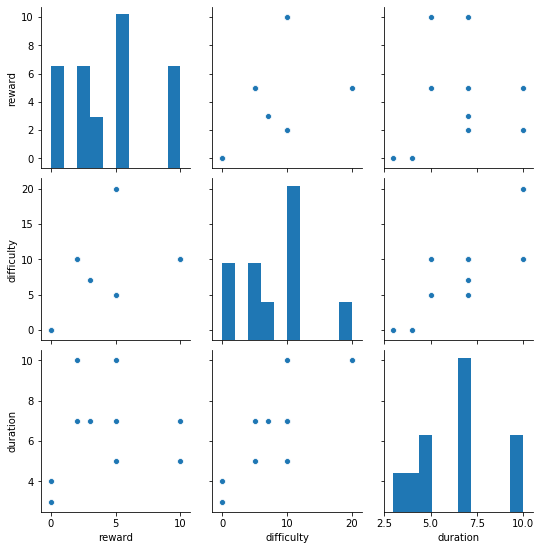

In [5]:
# Portfolio
display(portfolio.head(5))
sns.pairplot(portfolio)
display(quick_diagnostics(portfolio))

### 2.1.3 Profile
This table indicates customer demographic information such as age, gender, income, and joinning date. Few data missing, less than ~20% of data, on gender and income. I am planning to fill this with mode as turning it to 0 or leave it as NaN will make it hard to process during model trainning. Age also has few missing values indicated as 118 which need to be reformat later on. The format are ok with the exception of joining date. 

Age indicates customers are mostly old with 50 percentile 58YO - (might be encrypted?) and has normal distribution like shape. Income majority is low and gender mostly male.

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


Shape : (17000, 5) 


Features : ['gender', 'age', 'id', 'became_member_on', 'income'] 


Null values :
 gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64 


Descriptive statistics:
        gender           age                                id  \
count   14825  17000.000000                             17000   
unique      3           NaN                             17000   
top         M           NaN  98d80971baf94fd0ae06df25bb48bf14   
freq     8484           NaN                                 1   
mean      NaN     62.531412                               NaN   
std       NaN     26.738580                               NaN   
min       NaN     18.000000                               NaN   
25%       NaN     45.000000                               NaN   
50%       NaN     58.000000                               NaN   
75%       NaN     73.000000                               NaN   
max       NaN 

None

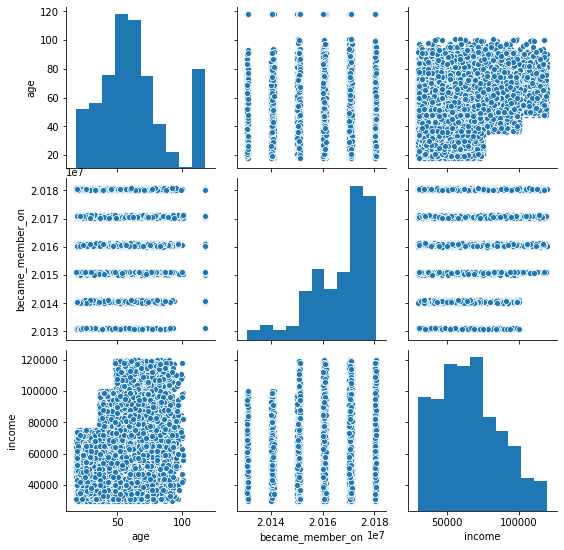

In [6]:
# Profile
display(profile.head(5))
sns.pairplot(profile)
display(quick_diagnostics(profile))

# 3 Methodology
## 3.1 Data Preprocessing

__Formating :__
* profile : reformat date, replace unified null values identificator
* portfolio : break channels into columns
* transcript : break value into columns

In [7]:
# Reformat profile - format age missing value (1/2)
profile_formatted = profile.copy()

boolean = profile_formatted.age>100
print(profile_formatted[boolean].age.value_counts())

profile_formatted.age = profile_formatted.age.replace(118,np.NaN)

print(profile_formatted[boolean].age.value_counts())

118    2175
101       5
Name: age, dtype: int64
101.0    5
Name: age, dtype: int64


In [8]:
# Reformat profile - format date time (2/2)

profile_formatted.became_member_on = profile.became_member_on.apply(
    lambda x :datetime.strptime(str(x), '%Y%m%d').date())

display(profile_formatted.head(5))

,gender,age,id,became_member_on,income
0,None,NaN,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0
2,None,NaN,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN
3,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0
4,None,NaN,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN


In [9]:
# Reformat portfolio
mlb = MultiLabelBinarizer()

transformed_column = portfolio.channels
portfolio_formatted = portfolio.join(
    pd.DataFrame(
        mlb.fit_transform(transformed_column),
        columns=mlb.classes_,
        index=portfolio.index)).drop(['channels'], axis =1)

display(portfolio_formatted)

,reward,difficulty,duration,offer_type,id,email,mobile,social,web
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1


In [11]:
# Reformat transcript

transcript_formatted = transcript.join(
    pd.DataFrame(
        pd.io.json.json_normalize(transcript.value),
        index=transcript.index)).drop(['value'], axis =1)

# Rename column to avoid confusion
transcript_formatted = transcript_formatted.rename(columns={
    "offer id" : "offer_id",
    "offer_id":"completed_offer_id",
    "reward":"reward_received"
}) 


# Merge offer_id column with completed_offer_id
transcript_formatted.offer_id.fillna(transcript_formatted.completed_offer_id, inplace=True)

display(transcript_formatted.head(5))

E:\Anaconda\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  """


,person,event,time,offer_id,amount,completed_offer_id,reward_received
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN



## 3.2 Feature Engineering
### 3.2.1 Aggregate data
Since we wanted to create clustering, the data will be achored at customers. Therefore, all information are aggregated and later group by customer. 


In [12]:
# Left join transcript and profile
agg = pd.merge(transcript_formatted, profile_formatted, left_on="person", right_on="id", how='left').drop(["id"],axis=1)

print("check transcript shape :",transcript_formatted.shape)
print("check profile :",profile_formatted.shape)
print("check aggregate shape :",agg.shape)
print("chech unique id :",agg.person.nunique())

display(agg.head(10))

check transcript shape : (306534, 7)
check profile : (17000, 5)
check aggregate shape : (306534, 11)
chech unique id : 17000


,person,event,time,offer_id,amount,completed_offer_id,reward_received,gender,age,became_member_on,income
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN,F,75.0,2017-05-09,100000.0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN,None,NaN,2017-08-04,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN,M,68.0,2018-04-26,70000.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN,None,NaN,2017-09-25,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN,None,NaN,2017-10-02,NaN
5,389bc3fa690240e798340f5a15918d5c,offer received,0,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN,NaN,M,65.0,2018-02-09,53000.0
6,c4863c7985cf408faee930f111475da3,offer received,0,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,NaN,NaN,None,NaN,2017-08-24,NaN
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,0,3f207df678b143eea3cee63160fa8bed,NaN,NaN,NaN,M,58.0,2017-11-11,51000.0
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN,F,61.0,2017-09-11,57000.0
9,31dda685af34476cad5bc968bdb01c53,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN,F,62.0,2016-02-11,71000.0


In [13]:
# Left join agg and portfolio
agg2 = pd.merge(agg,portfolio_formatted, left_on="offer_id", right_on="id", how='left').drop(["id"],axis=1)

print("check transcript shape :",agg.shape)
print("check profile :",portfolio_formatted.shape)
print("check aggregate shape :",agg2.shape)
print("chech unique id :",agg2.offer_id.nunique())

display(agg2.head(10))

check transcript shape : (306534, 11)
check profile : (10, 9)
check aggregate shape : (306534, 19)
chech unique id : 10


,person,event,time,offer_id,amount,completed_offer_id,reward_received,gender,age,became_member_on,income,reward,difficulty,duration,offer_type,email,mobile,social,web
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN,F,75.0,2017-05-09,100000.0,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN,None,NaN,2017-08-04,NaN,5.0,20.0,10.0,discount,1.0,0.0,0.0,1.0
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN,M,68.0,2018-04-26,70000.0,2.0,10.0,7.0,discount,1.0,1.0,0.0,1.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN,None,NaN,2017-09-25,NaN,2.0,10.0,10.0,discount,1.0,1.0,1.0,1.0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN,None,NaN,2017-10-02,NaN,10.0,10.0,5.0,bogo,1.0,1.0,1.0,1.0
5,389bc3fa690240e798340f5a15918d5c,offer received,0,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN,NaN,M,65.0,2018-02-09,53000.0,5.0,5.0,5.0,bogo,1.0,1.0,1.0,1.0
6,c4863c7985cf408faee930f111475da3,offer received,0,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,NaN,NaN,None,NaN,2017-08-24,NaN,3.0,7.0,7.0,discount,1.0,1.0,1.0,1.0
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,0,3f207df678b143eea3cee63160fa8bed,NaN,NaN,NaN,M,58.0,2017-11-11,51000.0,0.0,0.0,4.0,informational,1.0,1.0,0.0,1.0
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN,F,61.0,2017-09-11,57000.0,5.0,20.0,10.0,discount,1.0,0.0,0.0,1.0
9,31dda685af34476cad5bc968bdb01c53,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN,F,62.0,2016-02-11,71000.0,5.0,20.0,10.0,discount,1.0,0.0,0.0,1.0


### 3.2.2 Re-preprocess aggregated data
Data will be first cleaned by fill all the missing values due to table merged procedure. 

In [14]:
customer = agg2.copy()

#### Fill missing value with MOD for age, income, and gender column

In [15]:
# Fill missing value

# Age - fill na with mod
customer.age.fillna(agg2['age'].mode()[0], inplace=True)
print("age null value before :",agg2.age.isnull().sum(),"\nage null value after :", customer.age.isnull().sum())

# Income - fill na with mod
customer.income.fillna(agg2['income'].mode()[0], inplace=True)
print("\nincome null value before :",agg2.age.isnull().sum(),"\nincome null value after :", customer.age.isnull().sum())

# Gender - fill na with mod - To be encoded later
customer.gender.fillna(agg2['gender'].mode()[0], inplace=True)
print("\ngender null value before :",agg2.age.isnull().sum(),"\ngender null value after :", customer.age.isnull().sum())

customer.head(5)

age null value before : 33772 
age null value after : 0

income null value before : 33772 
income null value after : 0

gender null value before : 33772 
gender null value after : 0


,person,event,time,offer_id,amount,completed_offer_id,reward_received,gender,age,became_member_on,income,reward,difficulty,duration,offer_type,email,mobile,social,web
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN,F,75.0,2017-05-09,100000.0,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN,M,58.0,2017-08-04,73000.0,5.0,20.0,10.0,discount,1.0,0.0,0.0,1.0
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN,M,68.0,2018-04-26,70000.0,2.0,10.0,7.0,discount,1.0,1.0,0.0,1.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN,M,58.0,2017-09-25,73000.0,2.0,10.0,10.0,discount,1.0,1.0,1.0,1.0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN,M,58.0,2017-10-02,73000.0,10.0,10.0,5.0,bogo,1.0,1.0,1.0,1.0


#### Engineered new features for customers
`1.` Total item by event types (promotion viewed, completed, etc.)<br>
`2.` Total and average of amount spend and rewards received<br>
`3.` Total and rate of events by promotions type, difficulty, duration, and reward<br>
`4.` Total and rate of events by promotion channel<br>

In [16]:
# Feature engineering - create functions to generate rate of promotion completion (promotion completed/ promotion received)

####
#    Creates aggregate value based on 'events' column
#   
#    INPUT: transaction item
#            
#    OUTPUT: total value
#
#####

def sum_offer_received(trx):
    return np.sum(trx=="offer received")
def sum_offer_viewed(trx):
    return np.sum(trx=="offer viewed")
def sum_offer_completed(trx):
    return np.sum(trx=="offer completed")
def sum_transaction(trx):
    return np.sum(trx=="transaction")

####
#    Creates rate of promotion completion by promotion type 
#    
#    INPUT: 
#        dfsource : raw trx dataframe
#        anchor : groupby indicator 
#        var: type of variation 
#       dftotal : master table to collect total number of trx 
#        dfrate : master table to collect rate
#           
#   OUTPUT: merged table of total value
#
####   
 
def rating_generator1(dfsource,anchor,var,dftotal,dfrate) :
    if(not isinstance(dfsource[var][1], str)) :
        dfsource[var].fillna(0,inplace=True)
        dfsource[var]= dfsource[var].astype(int).astype(str)

    df= dfsource.groupby([anchor, var]).agg({
        'event':[sum_offer_received,sum_offer_completed],
            })
    df.columns = ["_".join(x) for x in df.columns.ravel()]
    df = df.unstack()
    df.columns = ["_".join(x)+"_"+var for x in df.columns.ravel()]
    
    dftemp = pd.merge(dftotal, df, on="person", how='left')

    type = dfsource[var].value_counts().index
    if(not isinstance(dfsource[var][1], str)) : type= type.astype(int).astype(str)

    for i in type :
        col_name = var+'_rate_'+i
        completed = 'event_sum_offer_completed_'+i+"_"+var
        received = 'event_sum_offer_received_'+i+"_"+var
        dfrate[col_name] = df[completed]/df[received]
    print(var," completed")
    return dftemp

####
#    Creates rate of promotion completion by promotion type 
#    
#    INPUT: 
#        dfsource : raw trx dataframe
#        anchor : groupby indicator 
#        var: type of variation 
#        dftotal : master table to collect total number of trx 
#        dfrate : master table to collect rate
#            
#    OUTPUT: merged table of total value
####

def rating_generator2(dfsource,anchor,var,dftotal,dfrate):
    df= dfsource[dfsource[var]==1].groupby([anchor]).agg({
        'event':[sum_offer_received,sum_offer_completed],
            })
    df.columns = ["_".join(x)+"_"+var for x in df.columns.ravel()]
    dftemp = pd.merge(dftotal, df, on="person", how='left')
    
    col_name = var+'_rate'
    completed = 'event_sum_offer_completed_'+var
    received = 'event_sum_offer_received_'+var
    dfrate[col_name] = df[completed]/df[received]
    print(var," completed")
    return dftemp

In [17]:
dfsource = customer.copy()
dfrate = pd.DataFrame()

* Create anchor table that has general overview of each users transaction. This table shows total promotion for each user by stages (received, viewed, etc)

In [18]:
dftotal = dfsource.groupby(['person']).agg({   
    'event': [sum_offer_received,sum_offer_viewed,sum_offer_completed,sum_transaction],
    'reward_received' :[nansum,nanmean],
    'amount' :[nansum,nanmean]
})
dftotal.columns = ["_".join(x) for x in dftotal.columns.ravel()]
dftotal['completed_rate'] = dftotal['event_sum_offer_completed']/dftotal['event_sum_offer_received']

display(dftotal.head(5))


,event_sum_offer_received,event_sum_offer_viewed,event_sum_offer_completed,event_sum_transaction,reward_received_nansum,reward_received_nanmean,amount_nansum,amount_nanmean,completed_rate
person,,,,,,,,,
0009655768c64bdeb2e877511632db8f,5,4,3,8,9.0,3.000000,127.60,15.950000,0.60
00116118485d4dfda04fdbaba9a87b5c,2,2,0,3,0.0,NaN,4.09,1.363333,0.00
0011e0d4e6b944f998e987f904e8c1e5,5,5,3,5,13.0,4.333333,79.46,15.892000,0.60
0020c2b971eb4e9188eac86d93036a77,5,3,3,8,14.0,4.666667,196.86,24.607500,0.60
0020ccbbb6d84e358d3414a3ff76cffd,4,4,3,12,13.0,4.333333,154.05,12.837500,0.75


* Next, we generate rating for each users by promotion variables to understand which promotion type work best

In [ ]:
rate_category = ['offer_type','reward','difficulty','duration']
rate_channel = ['mobile','web','email','social']
anchor = 'person'

for var in rate_category :
    dftotal = rating_generator1(dfsource,anchor,var,dftotal,dfrate)
    
for var in rate_channel :
    dftotal = rating_generator2(dfsource,anchor,var,dftotal,dfrate)

dffinal = pd.merge(dftotal, dfrate, on="person", how='left')
    

offer_type  completed
reward  completed
difficulty  completed


In [ ]:
# View output
display(dftotal.head(5))
display(dftotal.describe())
display(dfrate.head(5))
display(dfrate.describe())
display(dffinal.head(5))
display(dffinal.describe())

Based on the overview,
* users typically get 4-5 promotions in total within 30 days an completed about 2-3 which is around 50%
* users also typically transact up to 8 times
* in general, Discount seems to be more preferable to user as compare to BOGO
* the lower the reward, the rate seems to increase. this may due to its correlation with difficulty
* the longer the duration the higher the chance of completion
* as for channel, social seems to be leading followed by web, mobile and email

In [ ]:
# Sanity check
print("count bogo : ",dfsource[dfsource["offer_type"]=="bogo"]['person'].nunique())
print("count reward 5 : ",dfsource[dfsource["reward"]=="5"]['person'].nunique())
print("count difficulty 10 : ",dfsource[dfsource["difficulty"]=="10"]['person'].nunique())
print("count duration 4 : ",dfsource[dfsource["duration"]=="4"]['person'].nunique())

In [ ]:
# Sanity check
user_bool = dfsource.person=="0009655768c64bdeb2e877511632db8f"
received_bool = dfsource.event=="offer received"
completed_bool= dfsource.event=="offer completed"
condition_completed = user_bool *completed_bool
condition_received = user_bool *received_bool
display(dfsource[condition_completed])
display(dfsource[condition_received])

* Now that all extracted features are made, we join the demography information to the table

In [ ]:
# Add demography
demography=["person","age","gender","income"]
dfdemography = customer[demography].drop_duplicates(subset=None, keep='first', inplace=False)
dffinal_test = pd.merge(dffinal, dfdemography, on="person", how='left')


In [ ]:
# Ensure features all correct
dffinal_test.count()

## 3.3 Encode categorical value
Most cases machine learning only take numeric, therefore, any categorical value, in this case 'gender' id encoded with 'get dummy' method from pandas which convert the column into binary values. 

In [ ]:
# Encode multilevel column

multilevel_encoded = pd.get_dummies(dffinal_test.gender,prefix='gender')
print(multilevel_encoded.count())
multilevel_encoded.head(5)
dffinal_temp = pd.concat([dffinal_test,multilevel_encoded],axis=1) 
dffinal_temp = dffinal_temp.drop(['gender'],axis=1)

In [ ]:
# Set person as index
dffinal_temp = dffinal_temp.set_index(['person'])
dffinal_temp.head(1)

In [ ]:
dffinal_temp = dffinal_temp.fillna(0)

## 3.4 Scale
To not messing up with the distance, the number shall be scaled and normalize. Robust scaler is chosen since the data are not normally distributed.

In [ ]:
# Scale columns

# Apply feature scaling to the general population demographics data.

from sklearn.preprocessing import RobustScaler
rc = RobustScaler()
dffinal_scaled = rc.fit_transform(dffinal_temp)


## 3.5 Implement and Refinement

To optimize performance we'll implement PCA and refine the parameter to be as least as possible yet still maintaining the data representation.

As can be seen above, the top 15 principle components contain more than 97% of the variance in the dataset. Few parameters that extracted earlier also show at the top correlation listed. Those features are "event_sum_offer_completed", "event_sum_offer_completed_email","reward_received_nansum",  "amount_nansum", "event_sum_offer_completed_5_reward", "reward_received_nanmean".

This is good because the lower the pca the better the performance, it can be seen that hypothesis made during feature engineering profen to represent the data well enough. 


In [ ]:
# Apply PCA

from sklearn.decomposition import PCA

# Investigate the variance accounted for by each principal component.
def screen_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

In [ ]:
pca_50 = PCA(n_components=50)
dffinal_pca_50 = pca_50.fit_transform(dffinal_scaled)
pca_30 = PCA(n_components=30)
dffinal_pca_30  = pca_30.fit_transform(dffinal_scaled)
pca_20 = PCA(n_components=20)
dffinal_pca_20  = pca_20.fit_transform(dffinal_scaled)
pca_15 = PCA(n_components=15)
dffinal_pca_15 = pca_15.fit_transform(dffinal_scaled)
pca_10 = PCA(n_components=10)
dffinal_pca_10 = pca_10.fit_transform(dffinal_scaled)
pca_5 = PCA(n_components=5)
dffinal_pca_5 = pca_5.fit_transform(dffinal_scaled)



In [ ]:
screen_plot(pca_50)

In [ ]:
screen_plot(pca_30)

In [ ]:
screen_plot(pca_20)

In [ ]:
screen_plot(pca_15)

In [ ]:
screen_plot(pca_10)

In [ ]:
screen_plot(pca_5)

In [ ]:


print(pd.DataFrame(pca_10.components_[0].reshape((1, 83)), columns=dffinal_temp.columns,index = ['PC-1']).sort_values(ascending=False, axis=1, by='PC-1'))


In [ ]:
x = dffinal_pca_10

## 3.6 Implementation reflective
During this coding process, there are few challenges. 

What's good about this data is most of it are numeric already, so less decoding needs to be done. The only categorical feature left was gender, and using dummy function, this can be done in juat a line of code. 

Reformating the 'channel' - which was an array, and 'value'are quite unsually interesting. I finally managed to find a library that help me to do just that which was really helpful.

Choosing a the correct PCA was also rather tricky as whether we want to choose perfomance or quality. In this case, 10 is choosen because it has reached high percentage ~90% yet has very few principal components.I guess as data become bigger and computing process become longer, I would just go ahead with 7-9 pricipal components with the objective to reduce the computing time and maintain variance of > ~70%.  

# 4 Results
## 4.1 Model Evaluation and Validation

### 4.1.1 K-Means

For the model, we are using K-Means based on the initial data distribution can be seen in the exploration. The data is also rather dense with not much of outlier, which makes it suitable to use K-Means. I tried 2 max_iter to optimize the output, as well as n_init but the result is not too different. Both show that there is a crooked edge at 4. So instead of using the larger parameter, 300 and 10 is taken as performance wise it better and result wise, still deliver similar output. 

In [ ]:
from sklearn.cluster import KMeans

wcss = []
for i in range(1,11):
    km = KMeans(n_clusters = i, init = 'k-means++', max_iter =300, n_init =10, random_state = 42)
    km.fit(x)
    wcss.append(km.inertia_)
    
plt.plot(range(1,11), wcss)
plt.title('The Elbow Method', fontsize = 20)
plt.xlabel('No. of Clusters')
plt.ylabel('wcss')
plt.show()

In [ ]:
wcss = []
for i in range(1,11):
    km = KMeans(n_clusters = i, init = 'k-means++', max_iter =600, n_init =20, random_state = 42)
    km.fit(x)
    wcss.append(km.inertia_)
    
plt.plot(range(1,11), wcss)
plt.title('The Elbow Method', fontsize = 20)
plt.xlabel('No. of Clusters')
plt.ylabel('wcss')
plt.show()

In [ ]:
km = KMeans(n_clusters =4, init = 'k-means++', max_iter =300, n_init =10, random_state = 42)
km_model = km.fit_predict(x)

# Create cluster dataframe
df_x = pd.DataFrame(df_x).set_index(dffinal_temp.index)
cluster = pd.DataFrame(km_model).set_index(dffinal_temp.index)
cluster.columns = ['cluster']

# Merge cluster with all dataframes
km_rate = pd.merge(dffinal_temp, cluster, on='person') 
km_customer = pd.merge(customer, cluster, on='person')
km_pca = pd.merge(df_x, cluster, on='person')

sns.pairplot(km_pca, hue = 'cluster')

In [ ]:
ax = sns.violinplot(x="cluster", y="event_sum_offer_received", data=km_rate)

In [ ]:
ax = sns.violinplot(x="cluster", y="event_sum_offer_received", data=km_rate)

### 4.1.2 DBScan

In [ ]:
from sklearn.cluster import DBSCAN

In [ ]:
dbscan =  DBSCAN(eps=3,min_samples=170)
model = dbscan.fit_predict(x)
print("ncluster:",len(np.unique(model)))

In [ ]:
dbscan1 = DBSCAN(eps=1,min_samples=100)
model_1 = dbscan1.fit_predict(x)
print("ncluster:",len(np.unique(model_1)))

In [ ]:
dbscan2 = DBSCAN(eps=2,min_samples=100)
model_2 = dbscan2.fit_predict(x)
print("ncluster:",len(np.unique(model_2)))

In [ ]:
dbscan2_1 = DBSCAN(eps=2.5,min_samples=100)
model_2_1 = dbscan2_1.fit_predict(x)
print("ncluster:",len(np.unique(model_2_1)))

In [ ]:
dbscan2_2 = DBSCAN(eps=2.7,min_samples=100)
model_2_2 = dbscan2_1.fit_predict(x)
print("ncluster:",len(np.unique(model_2_2)))

In [ ]:
dbscan_0 =  DBSCAN(eps=2.01,min_samples=50)
model_0 = dbscan_0.fit_predict(x)
print("ncluster:",len(np.unique(model_0)))

In [ ]:
# Create cluster dataframe
df_x = pd.DataFrame(df_x).set_index(dffinal_temp.index)
cluster = pd.DataFrame(model_0).set_index(dffinal_temp.index)
cluster.columns = ['cluster']

# Merge cluster with all dataframes
dbs_rate = pd.merge(dffinal_temp, cluster, on='person') 
dbs_customer = pd.merge(customer, cluster, on='person')
dbs_pca = pd.merge(df_x, cluster, on='person')

sns.pairplot(dbs_pca, hue = 'cluster')

In [ ]:
ax = sns.violinplot(x="cluster", y="event_sum_offer_received", data=dbs_rate)

In [ ]:
ax = sns.violinplot(x="cluster", y="completed_rate", data=dbs_rate)

## 4.2 Justification
As mentioned above, 4 clusters are choosen based on the elbow chart. This clusters are also differentiated as can be jsutified in the descriptions as follows: 

There are 4 clusters with a quite differentiated characteristics. <br><br>
*__cluster 0:__ Received a lot of offer but the responses were mixed. This group is the one with least gap between male and female. They are relatively more older and affluent as compare to other groups. Duration doesn't seem to affect this group and this group is the one who prefer BOGO than any other. recommendation : month-long BOGO promotion made exclusive for more affluent segment<br><br>
*__cluster 1:__ Received a lot of offer but the response was low, dominated by male whom more likely to respond via mobile or web, and relatively OK with low to med level reward.They like discount more than BOGO, and prefer easy to medium difficulty that last 5–7 days as compare to the short ones. This group predominantly younger and has less  less income as compare to the rest. recommendation : low but frequent long lasting discount, targeted for male customers<br><br> 
*__cluster 2:__ This group receives quite a lot of promotions and also respond to almost all of them. Though still male dominated, this group has second least gap between and female indicating sizeable portion of women as compare to the other groups. They like small reward with high difficulty, that last for a week. Discount here is more preferred relative to BOGO. To reach them, web and social are the best channel. recommendation : challenging weekly discounts aired through the web targeted for medium to low income segment.<br><br>
*__cluster 3:__ This group not received as much promotions as other and not completing it as much as well. Uniquely, they seem to be relatively more responsive with high difficulty and high reward promotions. Majority male with relatively lower income, yet younger. Web still the best channel to reach this group. recommendation : try send more promotions to this group but provide ones with high reward. A week is sufficient and discount is more preferred


In [ ]:
# Create 4 clusters

km = KMeans(n_clusters =4, init = 'k-means++', max_iter =300, n_init =10, random_state = 42)
y_km = km.fit_predict(x)

In [ ]:
# Merge cluster identifier

cluster = pd.DataFrame(y_km).set_index(dffinal_temp.index)
cluster.columns = ['cluster']
dffinal_clustered = pd.merge(dffinal_temp, cluster, on='person') 
customer_clustered = pd.merge(customer, cluster, on='person')


In [ ]:
ax = sns.violinplot(x="cluster", y="event_sum_offer_received", data=dffinal_clustered)

In [ ]:
ax = sns.violinplot(x="cluster", y="completed_rate", data=dffinal_clustered)

In [ ]:
# Demography profile
# Gender
channel_rate = dffinal_clustered[['cluster','gender_F','gender_M','gender_O',]].groupby(['cluster']).sum()
channel_rate_stack = pd.DataFrame(channel_rate.stack()).reset_index()
channel_rate_stack.columns=['cluster','gender','value']

f, ax = plt.subplots(figsize=(15, 6))
ax = sns.barplot(x="cluster", y="value", hue='gender', data=channel_rate_stack)

In [ ]:
#age
ax = sns.violinplot(x="cluster", y="age", data=dffinal_clustered)

In [ ]:
# income
ax = sns.violinplot(x="cluster", y="income", data=dffinal_clustered)

In [ ]:
# By channel analysis
channel_rate = dffinal_clustered[['mobile_rate','web_rate','email_rate','social_rate','cluster']].groupby(['cluster']).mean()
channel_rate_stack = pd.DataFrame(channel_rate.stack()).reset_index()
channel_rate_stack.columns=['cluster','avg_channel_rate','value']

f, ax = plt.subplots(figsize=(15, 6))
ax = sns.barplot(x="avg_channel_rate", y="value", hue='cluster', data=channel_rate_stack)

In [ ]:
# By reward analysis
channel_rate = dffinal_clustered[['cluster','reward_rate_2','reward_rate_3','reward_rate_5','reward_rate_10',]].groupby(['cluster']).mean()
channel_rate_stack = pd.DataFrame(channel_rate.stack()).reset_index()
channel_rate_stack.columns=['cluster','avg_reward_rate','value']

f, ax = plt.subplots(figsize=(15, 6))
ax = sns.barplot(x="avg_reward_rate", y="value", hue='cluster', data=channel_rate_stack)

In [ ]:
# By Difficulty analysis

channel_rate = dffinal_clustered[['cluster',
 'difficulty_rate_5',
 'difficulty_rate_7',
 'difficulty_rate_10',
 'difficulty_rate_20']].groupby(['cluster']).mean()
channel_rate_stack = pd.DataFrame(channel_rate.stack()).reset_index()
channel_rate_stack.columns=['cluster','avg_difficulty_rate','value']

f, ax = plt.subplots(figsize=(15, 6))
ax = sns.barplot(x="avg_difficulty_rate", y="value", hue='cluster', data=channel_rate_stack)

In [ ]:
# By Duration analysis
channel_rate = dffinal_clustered[['cluster',
 'duration_rate_5',
 'duration_rate_7',
 'duration_rate_10',]].groupby(['cluster']).mean()
channel_rate_stack = pd.DataFrame(channel_rate.stack()).reset_index()
channel_rate_stack.columns=['cluster','avg_duration_rate','value']

f, ax = plt.subplots(figsize=(15, 6))
ax = sns.barplot(x="avg_duration_rate", y="value", hue='cluster', data=channel_rate_stack)

In [ ]:
# By Promotion analysis

channel_rate = dffinal_clustered[['cluster',
 'offer_type_rate_bogo',
 'offer_type_rate_discount',
 'offer_type_rate_informational',]].groupby(['cluster']).mean()
channel_rate_stack = pd.DataFrame(channel_rate.stack()).reset_index()
channel_rate_stack.columns=['cluster','avg_difficulty_rate','value']

f, ax = plt.subplots(figsize=(15, 6))
ax = sns.barplot(x="avg_difficulty_rate", y="value", hue='cluster', data=channel_rate_stack)

# 5 Conclusion
## 5.1 Reflection
	

Overall, the data was fairly clean and sufficient to be analyze. The proedure was fairly common with few perks that makes it interesting, 
- Data was cleaned and reformat. It was rather tricky as we have json and array format within a column that needs to 'unstack'. Other procedure was fairly common like filling missing value and rename few column. 
- Next, is data preprocessing and feature engineering. This stage is most laborous since there just numerous posibilities available to extract numbers that actually make difference in the clustering. I was using 'rate' as my main metrics and apply this to as much promotion type possible. Unfortunately, the PCA come out not as rewarding, since 10-20 dimesionality already covers the data. Yet at the same time, that means i have discovered few features that actually representative for all. Low pca also means good performance! 
- PCA and Modelling are fairly quick and as usual with few parameters tried. 
- Last step,which I find most interesting is making sense of the data and test all the hypothesis made during data preprocessing.  I was quite happy with the cluster as the number is small enough to be applied in real word, and the characters are fairly different from one to another. 

## 5.2 Improvement
	
For potential improvement, it will be interesting to:
- Creae one more additional feature which is the span time between the user received and complete as another informtion to help cluster the analysis
- Another clustering method such as DBSCAN, MeanShift, or Agglomerative clustering